# <center> Convolutional Neural Network

### Convolutional Layers: [128] ; Dense Layers [128]

CNN is trained on raw data

## <font color = 'blue'> Get the data

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from collections import defaultdict
from time import time

%store -r
%store

Stored variables and their in-db values:
X_test              -> defaultdict(<class 'list'>, {0: array([[[  9.38349
X_train             -> array([[[ 0.00880131,  0.00116885,  0.00790277, ..
snrs                -> [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 
y_test              -> defaultdict(<class 'list'>, {0: array([2, 6, 6, ..
y_train             -> array([3, 6, 0, ..., 0, 4, 6])


In [2]:
print("Training data: ", X_train.shape, "and labels: ", y_train.shape)
print()
print("Test data:")
print("Total", len(X_test), X_test[18].shape, "arrays for SNR values:")
print(sorted(X_test.keys()))

Training data:  (80000, 2, 128) and labels:  (80000,)

Test data:
Total 20 (4000, 2, 128) arrays for SNR values:
[-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


## <font color = 'blue'> Standardize the features

In [3]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
_X_train = np.reshape(X_train, [X_train.shape[0], X_train.shape[1]*X_train.shape[2]])
_X_train = sc.fit_transform(_X_train)

X_train = np.reshape(_X_train, X_train.shape)
print("Training set", X_train.shape)

_X_test = defaultdict(list)
for snr in snrs:
    _X_test[snr] = np.reshape(X_test[snr], [X_test[snr].shape[0], X_test[snr].shape[1]*X_test[snr].shape[2]])
    _X_test[snr] = sc.transform(_X_test[snr])
    X_test[snr] = np.reshape(_X_test[snr], X_test[snr].shape)
    
print("Test set corresponding to one snr value", X_test[18].shape)

Training set (80000, 2, 128)
Test set corresponding to one snr value (4000, 2, 128)


## <font color = 'blue'> Design and train the CNN

In [4]:
height = 2
width = 128
channels = 1
n_features = height * width

feature_map1 = 128
ksize_conv1 = 2
stride_conv1 = 1

pool_layer_maps1 = 128

n_fully_conn1 = 128

n_classes = 8
  
X = tf.placeholder(tf.float32, shape=[None, height, width])
X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
labels = tf.placeholder(tf.int32, shape=[None])

xavier_init = tf.contrib.layers.xavier_initializer()
relu_act = tf.nn.relu

# ------------------ Convolutional layers ----------------------------

def convolutional_layer(X, filter_, ksize, kernel_init, strides, padding):
    convolutional_layer = tf.layers.conv2d(X, filters = filter_, kernel_initializer = kernel_init,
                                           kernel_size = ksize, strides = strides,
                                          padding = padding, activation = relu_act)
    return convolutional_layer

conv_layer1 = convolutional_layer(X_reshaped, feature_map1, ksize_conv1, xavier_init, stride_conv1, padding = "SAME")

# ----------------- Pooling layers -------------------------------------

def pooling_layer(convlayer, ksize, strides, padding, pool_maps):
    pool = tf.nn.max_pool(convlayer, ksize, strides, padding)
    dim1, dim2 = int(pool.get_shape()[1]), int(pool.get_shape()[2])
    pool_flat = tf.reshape(pool, shape = [-1, pool_maps * dim1 * dim2])
    return pool_flat

pool_layer1_flat = pooling_layer(conv_layer1, [1,2,2,1], [1,2,2,1], "VALID", pool_layer_maps1 )

# ----------------- Fully connected layers -------------------

def dense_layer(input_layer, n_neurons, kernel_init, activation):
    fully_conn = tf.layers.dense(inputs = input_layer, units = n_neurons, activation = activation,
                                kernel_initializer = kernel_init)
    return fully_conn
        
dense_layer1 = dense_layer(pool_layer1_flat, n_fully_conn1, xavier_init, relu_act)

# ----------------- Output softmax layer ---------------------------

logits = tf.layers.dense(dense_layer1, n_classes)
softmax_activations = tf.nn.softmax(logits)

# ----------------- Specify performance measure -------------------------------

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits, labels = labels)
loss = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer()
train_operation = optimizer.minimize(loss)

correct_predictions = tf.nn.in_top_k(logits, labels, 1)
accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

# ---------------- Execution phase -------------------------------------------
    
n_epochs = 10
batch_size = 1024
n_train = X_train.shape[0]
n_iter = n_train//batch_size

acc_test = defaultdict(list)

path = "./CNN_narrow_deep0"  
saver = tf.train.Saver()

start = time()

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        for iteration in range(n_iter):
            rand_indices = np.random.choice(n_train,batch_size)    
            X_batch, y_batch = X_train[rand_indices], y_train[rand_indices]
            sess.run(train_operation, feed_dict={X: X_batch, labels: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, labels: y_batch})
        print("Epoch {} training accuracy : {}".format(epoch, acc_train))
        save_path = saver.save(sess, path)
        saver.restore(sess, path)
    saver.restore(sess, path)
    for snr in snrs:
        acc_test[snr] = accuracy.eval(feed_dict={X: X_test[snr], labels: y_test[snr]})

print("Training took %f minutes"%(float(time() - start)/60.0))

Epoch 0 training accuracy : 0.2060546875
INFO:tensorflow:Restoring parameters from ./CNN_narrow_deep0
Epoch 1 training accuracy : 0.2666015625
INFO:tensorflow:Restoring parameters from ./CNN_narrow_deep0
Epoch 2 training accuracy : 0.2607421875
INFO:tensorflow:Restoring parameters from ./CNN_narrow_deep0
Epoch 3 training accuracy : 0.27734375
INFO:tensorflow:Restoring parameters from ./CNN_narrow_deep0
Epoch 4 training accuracy : 0.3056640625
INFO:tensorflow:Restoring parameters from ./CNN_narrow_deep0
Epoch 5 training accuracy : 0.3193359375
INFO:tensorflow:Restoring parameters from ./CNN_narrow_deep0
Epoch 6 training accuracy : 0.3681640625
INFO:tensorflow:Restoring parameters from ./CNN_narrow_deep0
Epoch 7 training accuracy : 0.3916015625
INFO:tensorflow:Restoring parameters from ./CNN_narrow_deep0
Epoch 8 training accuracy : 0.400390625
INFO:tensorflow:Restoring parameters from ./CNN_narrow_deep0
Epoch 9 training accuracy : 0.40625
INFO:tensorflow:Restoring parameters from ./CNN_n

## <font color = 'blue'> Test the classifier

In [19]:
for snr in snrs:
    print("CNN's test accuracy on {}dB SNR samples = {}".format(snr,acc_test[snr]))  

CNN's test accuracy on -20dB SNR samples = 0.13300000131130219
CNN's test accuracy on -18dB SNR samples = 0.1264999955892563
CNN's test accuracy on -16dB SNR samples = 0.12950000166893005
CNN's test accuracy on -14dB SNR samples = 0.14174999296665192
CNN's test accuracy on -12dB SNR samples = 0.1457500010728836
CNN's test accuracy on -10dB SNR samples = 0.1912499964237213
CNN's test accuracy on -8dB SNR samples = 0.2692500054836273
CNN's test accuracy on -6dB SNR samples = 0.34700000286102295
CNN's test accuracy on -4dB SNR samples = 0.41449999809265137
CNN's test accuracy on -2dB SNR samples = 0.46000000834465027
CNN's test accuracy on 0dB SNR samples = 0.47999998927116394
CNN's test accuracy on 2dB SNR samples = 0.5097500085830688
CNN's test accuracy on 4dB SNR samples = 0.5435000061988831
CNN's test accuracy on 6dB SNR samples = 0.562250018119812
CNN's test accuracy on 8dB SNR samples = 0.559249997138977
CNN's test accuracy on 10dB SNR samples = 0.5717499852180481
CNN's test accurac

## <font color = 'blue'> Visualize classifier's performance on test set

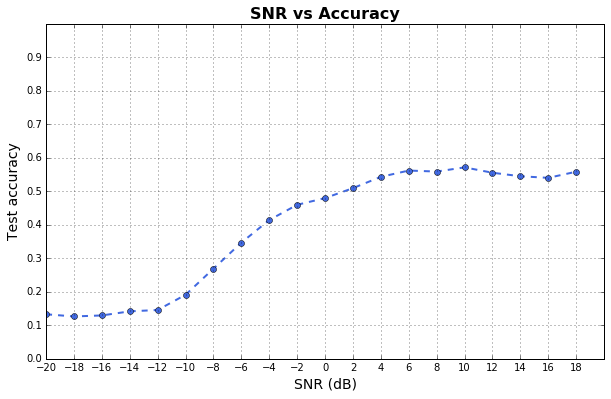

In [20]:
plt.style.use('classic')
%matplotlib inline

acc_test = sorted(acc_test.items())
new_acc = []
for i in range(len(acc_test)):
    new_acc.append(acc_test[i][1])
acc_test_values = new_acc 

fig1 = plt.figure(figsize=(10, 6), dpi=100)
x = snrs
y = list(acc_test_values)
plt.plot(x, y, marker="o", linewidth=2.0, linestyle='dashed', color='royalblue')
plt.axis([-20, 20, 0, 1])
plt.xticks(np.arange(min(x), max(x)+1, 2.0))
plt.yticks(np.arange(0, 1, 0.10))

ttl = plt.title('SNR vs Accuracy', fontsize=16)
ttl.set_weight('bold')
plt.xlabel('SNR (dB)', fontsize=14)
plt.ylabel('Test accuracy', fontsize=14)
plt.grid()

plt.show()

INFO:tensorflow:Restoring parameters from ./CNN_narrow_deep0
Confusion Matrix
       8PSK  BPSK  CPFSK  GFSK  PAM4  QAM16  QAM64  QPSK
8PSK   0.20  0.00   0.05  0.00  0.00   0.21   0.13  0.41
BPSK   0.01  0.89   0.00  0.00  0.08   0.00   0.01  0.02
CPFSK  0.14  0.00   0.61  0.09  0.00   0.02   0.02  0.12
GFSK   0.04  0.01   0.06  0.83  0.00   0.01   0.02  0.04
PAM4   0.00  0.24   0.00  0.00  0.74   0.01   0.01  0.00
QAM16  0.27  0.00   0.02  0.00  0.00   0.24   0.21  0.24
QAM64  0.10  0.00   0.00  0.00  0.00   0.37   0.42  0.11
QPSK   0.32  0.00   0.14  0.02  0.00   0.10   0.08  0.33


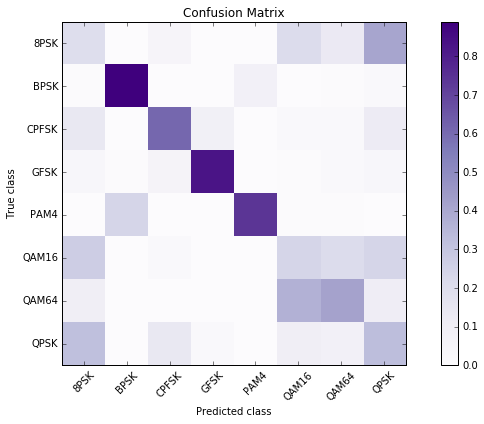

In [21]:
# Confusion Matrix

with tf.Session() as sess:
    saver.restore(sess, path)
    Z = logits.eval(feed_dict = {X : X_test[18]})
    predicted_18dB = np.argmax(Z, axis = 1)
    
from sklearn.metrics import confusion_matrix
%matplotlib inline

classes = ['8PSK', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK']
conf_matrix = confusion_matrix(predicted_18dB, y_test[18])  

conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix = conf_matrix.round(decimals = 2)

import pandas as pd

df = pd.DataFrame(data = conf_matrix, columns = classes, index = classes) 
print("Confusion Matrix")
print(df)

fig1 = plt.figure(figsize=(10, 6), dpi=100)
plt.imshow(conf_matrix, interpolation = 'nearest', cmap = plt.cm.Purples)
ticks = np.arange(len(classes))
plt.title("Confusion Matrix")
plt.xticks(ticks, classes, rotation=45)
plt.yticks(ticks, classes)

plt.ylabel('True class')
plt.xlabel('Predicted class')

plt.tight_layout()
plt.colorbar()
plt.show()